In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np
import os
import glob

import lmfit
from lmfit import Minimizer, Parameters, report_fit, Model

In [4]:
import pickle
    
def load_waveform_pickle(name):
    return pickle.load( open( f"{name}", "rb" ) )

In [5]:
# refs
# phenomTHM: https://arxiv.org/abs/2012.11923
# phenomT: https://arxiv.org/abs/2004.08302
# Nagar: https://arxiv.org/abs/2101.08624
# Nagar: https://arxiv.org/abs/2001.09082
# Nagar: https://arxiv.org/abs/1806.01772

# Xisco: https://arxiv.org/abs/1611.00332
# Keitel: https://arxiv.org/abs/1612.09566

# old example

In [6]:
def sech(x):
    return 1./np.cosh(x)

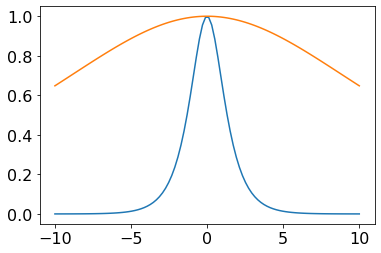

In [7]:
xx = np.linspace(-10, 10, 100)
plt.figure()
plt.plot(xx, sech(xx))
plt.plot(xx, sech(xx*0.1))
# plt.yscale('log')

In [41]:
# skewed sech?
# see 'skew': https://en.wikipedia.org/wiki/Hyperbolic_secant_distribution
def skew_sech(x, theta):
    """
    abs(theta) < pi/2
    """
    return 0.5 * np.cos(theta) * np.exp(theta*x) / np.cosh(0.5*np.pi*x)

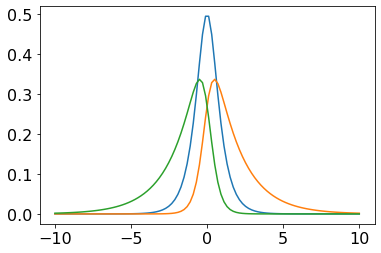

In [43]:
plt.figure()
plt.plot(xx, skew_sech(xx, 0))
plt.plot(xx, skew_sech(xx, 1))
plt.plot(xx, skew_sech(xx, -1))

# plt.yscale('log')

In [44]:
# derivative to get psi4
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [45]:
def get_some_data():
    q1_Res2 = load_waveform_pickle("data/q1_Res2.p")
    x = q1_Res2.times
    y = q1_Res2.amp
    phi = q1_Res2.phase
    tau = q1_Res2.nrstrain.fdamp*2*np.pi #2pi is important
    # omf = q1_Res2.nrstrain.fring
    
    h = y * np.exp(1.j*phi)
    
    ihre = IUS(x,np.real(h))
    ihim = IUS(x,np.imag(h))
    psi4re = ihre.derivative().derivative()(x)
    psi4im = ihim.derivative().derivative()(x)
    
    return x, y, tau, np.abs(psi4re - 1.j*psi4im)

In [46]:
x, y, tau, psi4_amp = get_some_data()

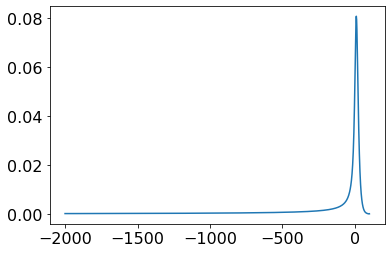

In [47]:
plt.figure()
plt.plot(x, psi4_amp)

In [48]:
np.pi/2.

1.5707963267948966

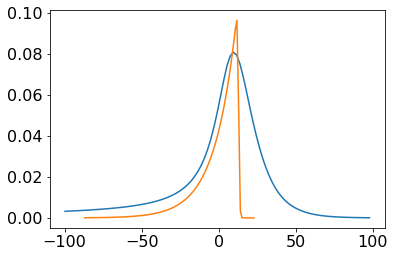

In [53]:
mask = (x > -100) & (x < 100)
xx_ = np.linspace(-100, 10, 100)
plt.figure()
# plt.plot(x[mask], y[mask])
plt.plot(x[mask], psi4_amp[mask])
plt.plot(xx_+13, skew_sech(xx_, -1.499)*1.5)
# plt.plot(xx_, skew_sech(xx_, -1.499)**(1/20.))
# plt.xlim(-20, 10)
# plt.yscale('log')

In [255]:
class Model_Amp_Merger(object):
    def __init__(self, x, y, fdamp):
        self.x = x
        self.y = y
        self.fdamp = fdamp
        
    def ansatz(self, params, t):
        
        a1 = params['a1']
        
        b0 = params['b0']
        b1 = params['b1']
        b2 = params['b2']
        b3 = params['b3']
        
        model = b0 + b1*t**2 + b2*sech(2*a1*t)**(1/7.) + b3*sech(a1*t)
        
        # should do model selection on the power e.g. 1/8 seems to fit a bit better
#         model = b0 + b1*t**2 + b2*sech(2*a1*t)**(1/8.) + b3*sech(a1*t)
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-100, t2=0):
        """
        # should add an loop here to avoid getting stuck in local minima
        # see: https://gitlab.com/SpaceTimeKhantinuum/presentations/-/blob/master/nov2020-cardiff-data-analysis/waveforms.ipynb
        """

        self.mask = (self.x > t1) & (self.x < t2)
        self.fit_times = self.x[self.mask]
        self.fit_data = self.y[self.mask]
        
        # create a set of Parameters
        params = Parameters()
#         params.add('b0', value=np.random.uniform(-200,200), min=-200, max=200)
        params.add('b0', value=0, vary=True)
        params.add('b1', value=0, vary=True)
        params.add('b2', value=0, vary=True)
        params.add('b3', value=0, vary=True)
        params.add('a1', value=self.fdamp, vary=False)
        
#         params.add('c', value=0, min=-200, max=200, vary=False)
#         params.add('d', value=0, min=-200, max=200, vary=False)
#         params.add('e', value=0, min=-200, max=200, vary=False)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        
        # add uncertainty
        # 1-sigma error
        # https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult.eval_uncertainty
#         dely = self.result.eval_uncertainty(3)
#         axes[0].fill_between(fit_times, fit_result-dely, fit_result+dely, color='#888888')
        
        
        
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [519]:
!ls data

q10_IMRPhenomB.p q18_SEOBNRv4.p   q2_IMRPhenomD.p  q4_SEOBNRv4.p
q10_IMRPhenomC.p q1_IMRPhenomB.p  q2_Res3.p        q5_IMRPhenomB.p
q10_IMRPhenomD.p q1_IMRPhenomC.p  q2_Res4.p        q5_IMRPhenomC.p
q10_Res3.p       q1_IMRPhenomD.p  q2_Res5.p        q5_IMRPhenomD.p
q10_Res4.p       q1_Res2.p        q2_SEOBNRv4.p    q5_Res3.p
q10_Res5.p       q1_Res3.p        q4_IMRPhenomB.p  q5_Res4.p
q10_SEOBNRv4.p   q1_Res4.p        q4_IMRPhenomC.p  q5_Res5.p
q18_IMRPhenomB.p q1_SEOBNRv4.p    q4_IMRPhenomD.p  q5_SEOBNRv4.p
q18_IMRPhenomC.p q2_IMRPhenomB.p  q4_Res3.p
q18_IMRPhenomD.p q2_IMRPhenomC.p  q4_Res5.p


In [334]:
q1_Res2 = load_waveform_pickle("data/q10_Res4.p")

In [335]:
x = q1_Res2.times
y = q1_Res2.amp
tau = q1_Res2.nrstrain.fdamp*2*np.pi #2pi is important
# omf = q1_Res2.nrstrain.fring

In [336]:
tau

0.0887110562381201

In [337]:
omf

0.071861616911234

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 7.6292e-04
    reduced chi-square = 1.7339e-05
    Akaike info crit   = -522.378882
    Bayesian info crit = -514.894078
[[Variables]]
    b0:  0.14000706 +/- 0.00734016 (5.24%) (init = 0)
    b1: -3.5531e-06 +/- 7.3702e-07 (20.74%) (init = 0)
    b2: -0.03614288 +/- 0.01696796 (46.95%) (init = 0)
    b3:  0.10308764 +/- 0.01078619 (10.46%) (init = 0)
    a1:  0.08871106 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.968
    C(b1, b2) =  0.938
    C(b0, b3) =  0.917
    C(b1, b3) = -0.854


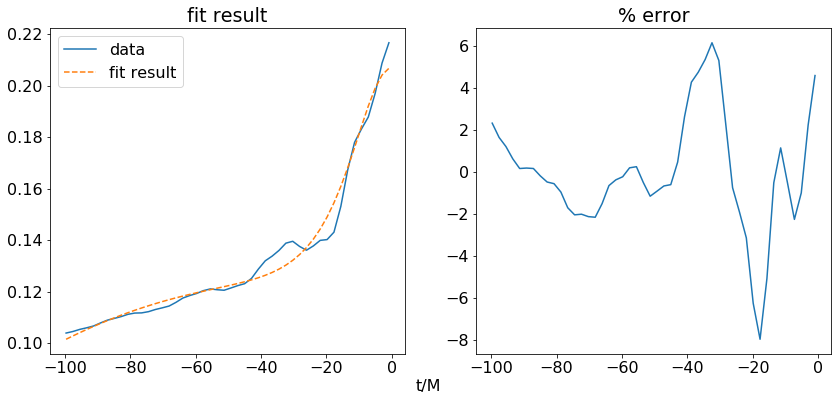

In [338]:
example_fit = Model_Amp_Merger(x, y, tau)
example_fit.fit(-100, 0)
example_fit.plot_result() 

In [14]:
glob.glob("data/q1_*")

['data/q1_Res4.p',
 'data/q1_IMRPhenomC.p',
 'data/q1_Res3.p',
 'data/q1_IMRPhenomD.p',
 'data/q1_Res2.p',
 'data/q1_IMRPhenomB.p',
 'data/q1_SEOBNRv4.p']

In [21]:
def load_mass_ratio_case(q):
    """
    q : integer. q in [1,2,3,4,5,10]
    """
    
    name = f"q{int(q)}"
    
    res = {}
    paths = glob.glob(f"data/{name}_*")
    for path in paths:
        key = path.split('/')[-1]
        res.update({key:load_waveform_pickle(path)})
    
    return res

In [524]:
q10data = load_mass_ratio_case(10)

In [525]:
q10data

{'q10_Res4.p': <utils.WaveformGeneration at 0x1a2f53c2d0>,
 'q10_IMRPhenomB.p': <utils.WaveformGeneration at 0x1a2a753a90>,
 'q10_Res3.p': <utils.WaveformGeneration at 0x1a2a753550>,
 'q10_IMRPhenomC.p': <utils.WaveformGeneration at 0x1a2a753b50>,
 'q10_IMRPhenomD.p': <utils.WaveformGeneration at 0x1a2a753650>,
 'q10_SEOBNRv4.p': <utils.WaveformGeneration at 0x1a2a753b10>,
 'q10_Res5.p': <utils.WaveformGeneration at 0x1a2a753fd0>}

In [526]:
q10data.items()

dict_items([('q10_Res4.p', <utils.WaveformGeneration object at 0x1a2f53c2d0>), ('q10_IMRPhenomB.p', <utils.WaveformGeneration object at 0x1a2a753a90>), ('q10_Res3.p', <utils.WaveformGeneration object at 0x1a2a753550>), ('q10_IMRPhenomC.p', <utils.WaveformGeneration object at 0x1a2a753b50>), ('q10_IMRPhenomD.p', <utils.WaveformGeneration object at 0x1a2a753650>), ('q10_SEOBNRv4.p', <utils.WaveformGeneration object at 0x1a2a753b10>), ('q10_Res5.p', <utils.WaveformGeneration object at 0x1a2a753fd0>)])

In [527]:
plt.figure(figsize=(14, 8))
for k,v in q10data.items():
    plt.plot(v.times, v.amp, label=f'{k}')
plt.legend()

In [39]:
import phenom

In [43]:
def get_fdamp(q):
    eta = phenom.eta_from_q(q)
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    fdamp = phenom.remnant.fdamp(eta, 0, 0, fin_spin)
    return fdamp

In [44]:
get_fdamp(1)

0.013595523411814124

In [45]:
qs = [1,2,3,4,5,10]
data = {}
for q in qs:
    data.update({q:load_mass_ratio_case(q)})

In [55]:
def fit_cases(data, q):
    
    fit_results = {}
    
    for k,v in data[q].items():
        print("\n\n=============")
        print(f"working case: {k}")
        print("=============\n\n")
    
        x = v.times
        y = v.amp
        tau = get_fdamp(q)*2*np.pi #2pi is important
    
    
        fit = Model_Amp_Merger(x, y, tau)
        fit.fit(-100, 0)
        fit.plot_result() 
        
        fit_results.update({k:fit})
        
    return fit_results



working case: q10_Res4.p


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 1.7248e-07
    reduced chi-square = 3.9199e-09
    Akaike info crit   = -925.321720
    Bayesian info crit = -917.836916
[[Variables]]
    b0:  0.07721690 +/- 1.1037e-04 (0.14%) (init = 0)
    b1: -2.9902e-07 +/- 1.1082e-08 (3.71%) (init = 0)
    b2:  0.04007776 +/- 2.5513e-04 (0.64%) (init = 0)
    b3:  0.00308422 +/- 1.6218e-04 (5.26%) (init = 0)
    a1:  0.08871106 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.968
    C(b1, b2) =  0.938
    C(b0, b3) =  0.917
    C(b1, b3) = -0.854


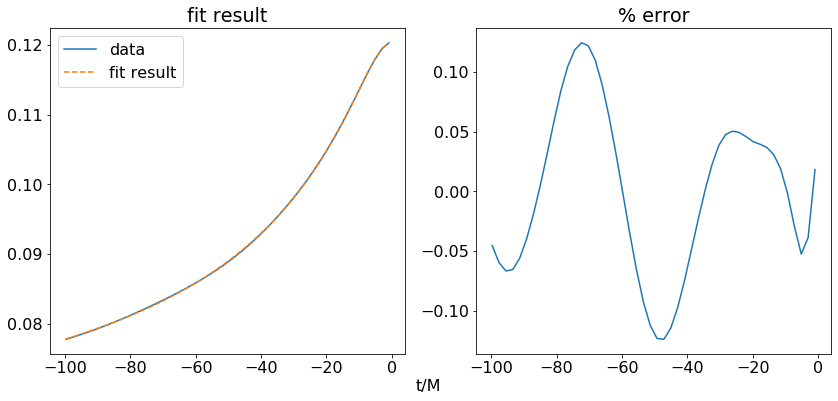



working case: q10_IMRPhenomB.p


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 7.6292e-04
    reduced chi-square = 1.7339e-05
    Akaike info crit   = -522.378883
    Bayesian info crit = -514.894079
[[Variables]]
    b0:  0.14000705 +/- 0.00734016 (5.24%) (init = 0)
    b1: -3.5531e-06 +/- 7.3702e-07 (20.74%) (init = 0)
    b2: -0.03614287 +/- 0.01696796 (46.95%) (init = 0)
    b3:  0.10308764 +/- 0.01078619 (10.46%) (init = 0)
    a1:  0.08871106 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.968
    C(b1, b2) =  0.938
    C(b0, b3) =  0.917
    C(b1, b3) = -0.854


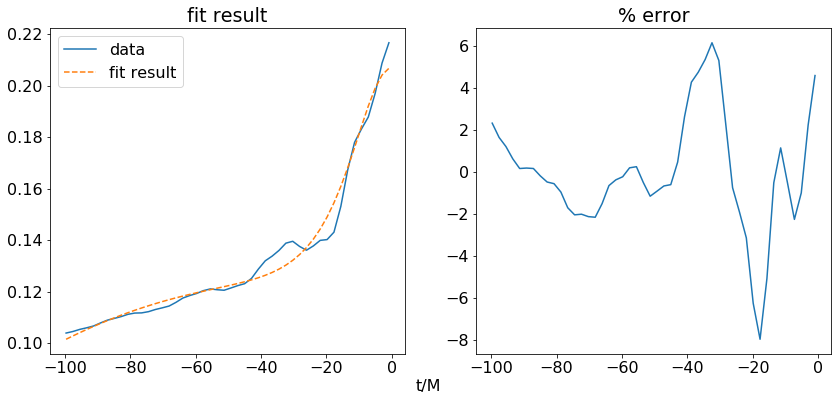



working case: q10_Res3.p


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 2.4130e-07
    reduced chi-square = 5.4842e-09
    Akaike info crit   = -909.203484
    Bayesian info crit = -901.718680
[[Variables]]
    b0:  0.07720782 +/- 1.3054e-04 (0.17%) (init = 0)
    b1: -2.9806e-07 +/- 1.3108e-08 (4.40%) (init = 0)
    b2:  0.04013520 +/- 3.0177e-04 (0.75%) (init = 0)
    b3:  0.00305812 +/- 1.9183e-04 (6.27%) (init = 0)
    a1:  0.08871106 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.968
    C(b1, b2) =  0.938
    C(b0, b3) =  0.917
    C(b1, b3) = -0.854


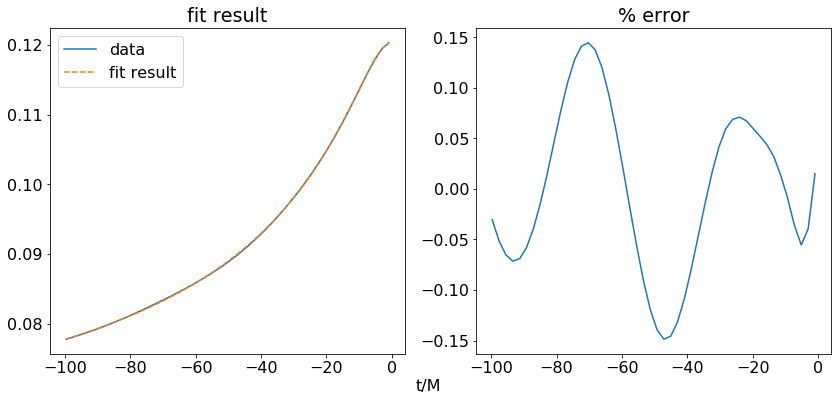



working case: q10_IMRPhenomC.p


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 1.7578e-04
    reduced chi-square = 3.9949e-06
    Akaike info crit   = -592.840093
    Bayesian info crit = -585.355289
[[Variables]]
    b0:  0.11643437 +/- 0.00352327 (3.03%) (init = 0)
    b1: -1.5041e-06 +/- 3.5377e-07 (23.52%) (init = 0)
    b2:  0.02199801 +/- 0.00814460 (37.02%) (init = 0)
    b3:  0.00823928 +/- 0.00517736 (62.84%) (init = 0)
    a1:  0.08871106 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.968
    C(b1, b2) =  0.938
    C(b0, b3) =  0.917
    C(b1, b3) = -0.854


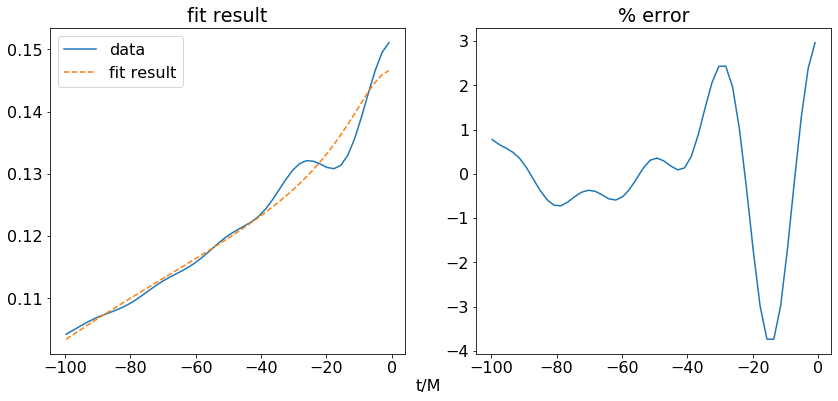



working case: q10_IMRPhenomD.p


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 4.2354e-07
    reduced chi-square = 9.6260e-09
    Akaike info crit   = -882.198812
    Bayesian info crit = -874.714007
[[Variables]]
    b0:  0.08154716 +/- 1.7295e-04 (0.21%) (init = 0)
    b1: -3.8505e-07 +/- 1.7365e-08 (4.51%) (init = 0)
    b2:  0.02512626 +/- 3.9980e-04 (1.59%) (init = 0)
    b3:  0.01461115 +/- 2.5414e-04 (1.74%) (init = 0)
    a1:  0.08871106 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.968
    C(b1, b2) =  0.938
    C(b0, b3) =  0.917
    C(b1, b3) = -0.854


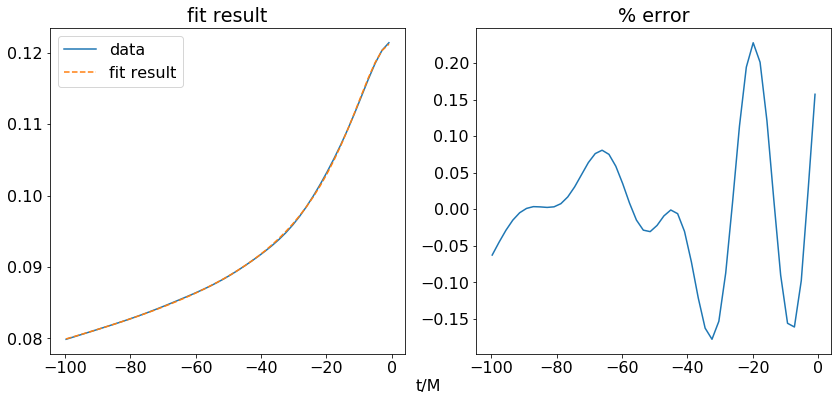



working case: q10_SEOBNRv4.p


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 6.6036e-07
    reduced chi-square = 1.5008e-08
    Akaike info crit   = -860.880832
    Bayesian info crit = -853.396028
[[Variables]]
    b0:  0.07686536 +/- 2.1595e-04 (0.28%) (init = 0)
    b1: -2.4350e-07 +/- 2.1683e-08 (8.91%) (init = 0)
    b2:  0.04314552 +/- 4.9921e-04 (1.16%) (init = 0)
    b3:  0.00143092 +/- 3.1734e-04 (22.18%) (init = 0)
    a1:  0.08871106 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.968
    C(b1, b2) =  0.938
    C(b0, b3) =  0.917
    C(b1, b3) = -0.854




working case: q10_Res5.p


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 2.0100e-07
    reduced chi-square = 4.5682e-09
    Akaike info crit   = -917.975990
    Bayesian info crit = -910.491185
[[Variables]]
    b0:  0.07719543 +/- 1.1914e-04 (0.15%) (init = 0)
    b1: -2.9486e-07 +/- 1.1963e-08 (4.06%) (init = 0)
    b2:  0.04018056 +/- 2.7541e-04 (0.69%) (init = 0)
    b3:  0.00302858 +/- 1.7508e-04 (5.78%) (init = 0)
    a1:  0.08871106 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.968
    C(b1, b2) =  0.938
    C(b0, b3) =  0.917
    C(b1, b3) = -0.854


In [84]:
fit_results = fit_cases(data, 10)

In [99]:
fit_results[list(fit_results.keys())[0]].result

In [100]:
fit_results[list(fit_results.keys())[0]].result.params['b0'].value

0.07721689970570748

In [98]:
fit_results[list(fit_results.keys())[0]].result.params['b0'].stderr

0.00011036523382173622

In [86]:
fit_results[list(fit_results.keys())[0]].result.bic

-917.8369155992743

In [87]:
bics = {}
for k,v in fit_results.items():
    bics.update({k:v.result.bic})

In [88]:
bics

{'q10_Res4.p': -917.8369155992743,
 'q10_IMRPhenomB.p': -514.8940794291791,
 'q10_Res3.p': -901.7186795456577,
 'q10_IMRPhenomC.p': -585.3552885540614,
 'q10_IMRPhenomD.p': -874.7140074931922,
 'q10_SEOBNRv4.p': -853.3960280004908,
 'q10_Res5.p': -910.4911854941487}

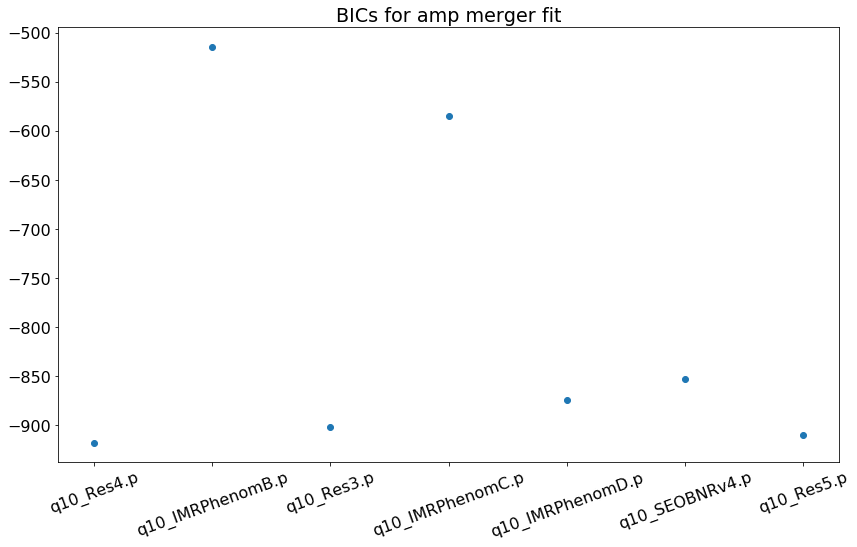

In [89]:
positions = range(len(bics))
plt.figure(figsize=(14, 8))
plt.scatter(positions, bics.values())
labels = list(bics.keys())
plt.xticks(positions, labels, rotation=20)
plt.title("BICs for amp merger fit");

In [164]:
def get_coeffs(fit_results):
    results={}
    for k,v in fit_results.items():
        params = v.result.params
        results.update({k:{}})
        for param_k, param_v in params.items():
            results[k].update({param_k:{'value':param_v.value, 'stderr':param_v.stderr}})
            
    return results

In [179]:
def get_x_y_yerr(coeffs_dict, param):
    # construct arrays to plot
    values = [coeff_results[key][param]['value'] for key in coeff_results.keys()]
    
    # the 1d sigma i.e. (sqrt(cov[i,i]))
    errors = [coeff_results[key][param]['stderr'] for key in coeff_results.keys()]
    
    x = np.arange(len(values))
    labels = list(coeff_results.keys())
    
    return x, values, errors, labels

In [225]:
def plot_coeffs(x, y, yerr, labels, ylim=None):
    
    plt.figure(figsize=(14, 4))
    plt.errorbar(x, y, yerr=yerr, ls='', marker='o')
    
    plt.xticks(x, labels, rotation=20)
    
    if ylim:
        plt.ylim(ylim)
    
    plt.show()
    plt.close()

In [220]:
coeff_results = get_coeffs(fit_results)

In [221]:
x, y, yerr, labels = get_x_y_yerr(coeff_results, 'b0')

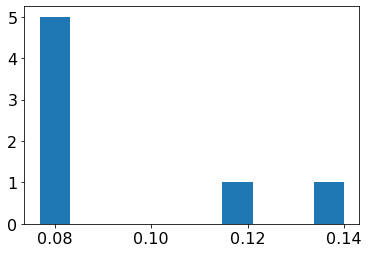

In [222]:
plt.figure()
plt.hist(y);

In [223]:
y

[0.07721689970570748,
 0.14000705411423606,
 0.07720782235894066,
 0.11643436585273445,
 0.08154715758032002,
 0.0768653568680283,
 0.07719543477192352]

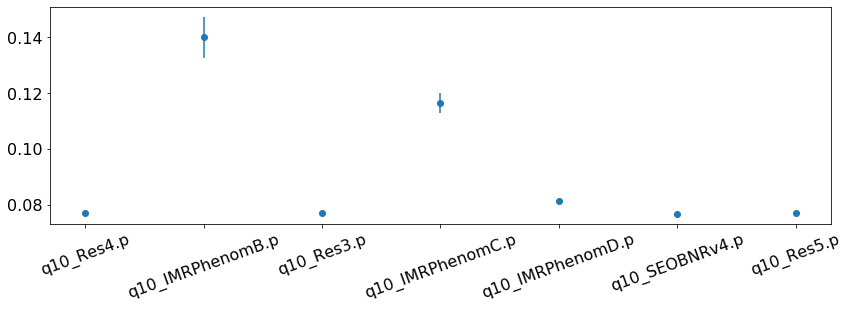

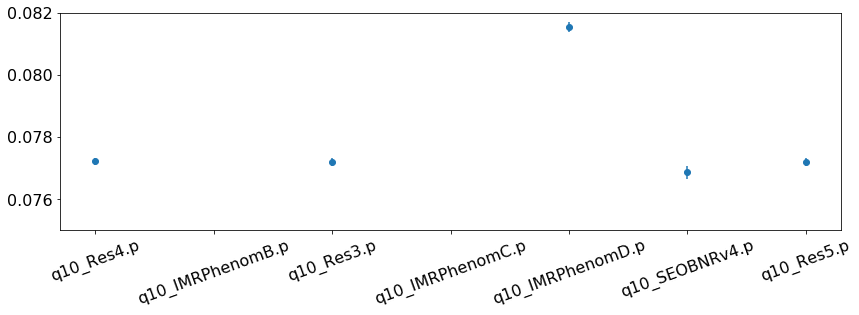

In [227]:
plot_coeffs(x, y, yerr, labels)

# zoom
plot_coeffs(x, y, yerr, labels, (0.075,0.082))

# newer using lmfit.Model

In [376]:
import phenom

In [377]:
def get_fdamp(q):
    eta = phenom.eta_from_q(q)
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    fdamp = phenom.remnant.fdamp(eta, 0, 0, fin_spin)
    return fdamp

In [378]:
get_fdamp(1)

0.013595523411814124

In [533]:
# qs = [1,2,3,4,5,10]
qs = [1,2,3,4,5,10,18]
data = {}
for q in qs:
    data.update({q:load_mass_ratio_case(q)})

In [534]:
# so that i can get confidence bands need to use lmfit.Model

In [535]:
def amp_merger_ansatz(t, b0, b1, b2, b3, a1):
    """
    equation 16 from 2004.08302
    """
    model = b0 + b1*t**2 + b2*sech(2*a1*t)**(1/7.) + b3*sech(a1*t)
    # should do model selection on the power e.g. 1/8 seems to fit a bit better
#         model = b0 + b1*t**2 + b2*sech(2*a1*t)**(1/8.) + b3*sech(a1*t)
    return model

In [536]:
amp_merger_ansatz(np.array([-100, 9]), 0,0,0,1,1)

array([7.44015195e-44, 2.46819604e-04])

In [537]:
def fit(q, x, y, x1, x2, ansatz, plot=True):
    
    mask = (x>=x1) & (x<=x2)
    x = x[mask]
    y = y[mask]
    
    mod = Model(ansatz, independent_vars=['t'])
    
    pars = mod.make_params()
    
    for k in pars.keys():
        pars[k].value = 0
    
    pars['a1'].value=get_fdamp(q)*2*np.pi
    pars['a1'].vary=False
    
    result = mod.fit(y, pars, t=x)
    
    if plot:

        print(result.fit_report())

        plt.plot(x, y, 'bo')
    #     plt.plot(x, result.init_fit, 'k--', label='initial fit')
        plt.plot(x, result.best_fit, 'r-', label='best fit')

        for s in [2,1]:
            dely = result.eval_uncertainty(t=x, sigma=s)
            plt.fill_between(x, result.best_fit-dely,
                             result.best_fit+dely, label=fr'{s}\sigma')

        plt.legend(loc='best')
        plt.show()

    return result

[[Model]]
    Model(amp_merger_ansatz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 48
    # variables        = 4
    chi-square         = 4.8280e-07
    reduced chi-square = 1.0973e-08
    Akaike info crit   = -875.913111
    Bayesian info crit = -868.428307
[[Variables]]
    b0:  0.22195284 +/- 2.0081e-04 (0.09%) (init = 0)
    b1: -1.0205e-06 +/- 1.9547e-08 (1.92%) (init = 0)
    b2:  0.15010769 +/- 4.5568e-04 (0.30%) (init = 0)
    b3:  0.02070338 +/- 2.8304e-04 (1.37%) (init = 0)
    a1:  0.08542319 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.985
    C(b0, b1) = -0.978
    C(b2, b3) = -0.971
    C(b1, b2) =  0.943
    C(b0, b3) =  0.924
    C(b1, b3) = -0.865


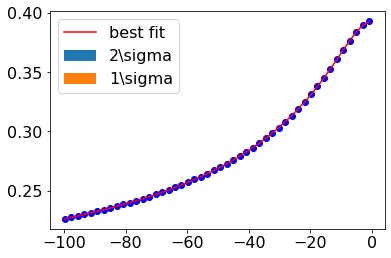

In [538]:
result = fit(
    1,
    data[1]['q1_Res4.p'].times,
    data[1]['q1_Res4.p'].amp,
    -100,
    0,
    amp_merger_ansatz,
    plot=True
)

In [672]:
def fit_cases(data, q):
    
    fit_results = {}
    
    for k,v in data[q].items():
        
#         if "PhenomC" in k:
#             continue
#         if "PhenomB" in k:
#             continue
        
        print("\n\n=============")
        print(f"working case: {k}")
        print("=============\n\n")
    
        x = v.times
        y = v.amp

        ##
        result = fit(q, x, y, -100, 0, amp_merger_ansatz, plot=True)
        fit_results.update({k:result})
        ##
        
        
    return fit_results



working case: q5_Res3.p


[[Model]]
    Model(amp_merger_ansatz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 3.3713e-07
    reduced chi-square = 7.6620e-09
    Akaike info crit   = -893.151921
    Bayesian info crit = -885.667117
[[Variables]]
    b0:  0.12709706 +/- 1.5601e-04 (0.12%) (init = 0)
    b1: -5.8351e-07 +/- 1.5601e-08 (2.67%) (init = 0)
    b2:  0.07252128 +/- 3.5974e-04 (0.50%) (init = 0)
    b3:  0.00721218 +/- 2.2797e-04 (3.16%) (init = 0)
    a1:  0.08826666 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.969
    C(b1, b2) =  0.939
    C(b0, b3) =  0.918
    C(b1, b3) = -0.856


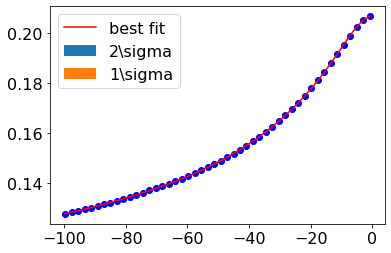



working case: q5_IMRPhenomB.p


[[Model]]
    Model(amp_merger_ansatz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 48
    # variables        = 4
    chi-square         = 0.00133354
    reduced chi-square = 3.0308e-05
    Akaike info crit   = -495.573901
    Bayesian info crit = -488.089097
[[Variables]]
    b0:  0.19547581 +/- 0.00981183 (5.02%) (init = 0)
    b1: -4.0074e-06 +/- 9.8118e-07 (24.48%) (init = 0)
    b2:  0.00177877 +/- 0.02262505 (1271.95%) (init = 0)
    b3:  0.04044195 +/- 0.01433800 (35.45%) (init = 0)
    a1:  0.08826666 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.969
    C(b1, b2) =  0.939
    C(b0, b3) =  0.918
    C(b1, b3) = -0.856


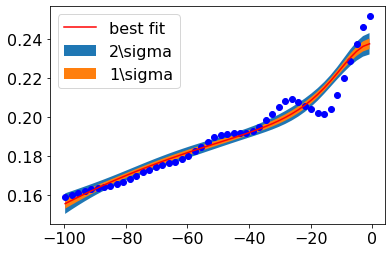



working case: q5_Res4.p


[[Model]]
    Model(amp_merger_ansatz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 2.3012e-07
    reduced chi-square = 5.2300e-09
    Akaike info crit   = -911.481404
    Bayesian info crit = -903.996600
[[Variables]]
    b0:  0.12709750 +/- 1.2889e-04 (0.10%) (init = 0)
    b1: -5.7118e-07 +/- 1.2889e-08 (2.26%) (init = 0)
    b2:  0.07225532 +/- 2.9721e-04 (0.41%) (init = 0)
    b3:  0.00733562 +/- 1.8835e-04 (2.57%) (init = 0)
    a1:  0.08826666 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.969
    C(b1, b2) =  0.939
    C(b0, b3) =  0.918
    C(b1, b3) = -0.856


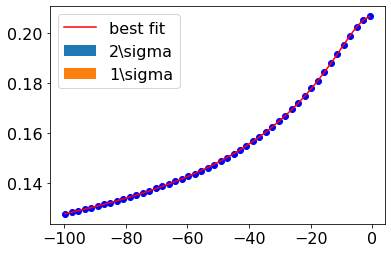



working case: q5_SEOBNRv4.p


[[Model]]
    Model(amp_merger_ansatz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 1.2345e-06
    reduced chi-square = 2.8057e-08
    Akaike info crit   = -830.849746
    Bayesian info crit = -823.364942
[[Variables]]
    b0:  0.12627165 +/- 2.9853e-04 (0.24%) (init = 0)
    b1: -4.7826e-07 +/- 2.9853e-08 (6.24%) (init = 0)
    b2:  0.07716822 +/- 6.8839e-04 (0.89%) (init = 0)
    b3:  0.00389064 +/- 4.3625e-04 (11.21%) (init = 0)
    a1:  0.08826666 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.969
    C(b1, b2) =  0.939
    C(b0, b3) =  0.918
    C(b1, b3) = -0.856


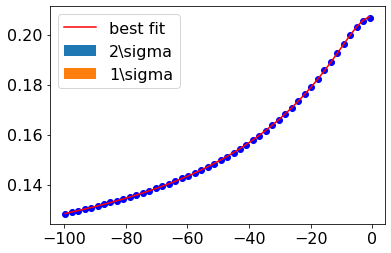



working case: q5_Res5.p


[[Model]]
    Model(amp_merger_ansatz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 2.7914e-07
    reduced chi-square = 6.3441e-09
    Akaike info crit   = -902.212099
    Bayesian info crit = -894.727295
[[Variables]]
    b0:  0.12717674 +/- 1.4196e-04 (0.11%) (init = 0)
    b1: -5.7855e-07 +/- 1.4196e-08 (2.45%) (init = 0)
    b2:  0.07210859 +/- 3.2734e-04 (0.45%) (init = 0)
    b3:  0.00746164 +/- 2.0744e-04 (2.78%) (init = 0)
    a1:  0.08826666 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.969
    C(b1, b2) =  0.939
    C(b0, b3) =  0.918
    C(b1, b3) = -0.856


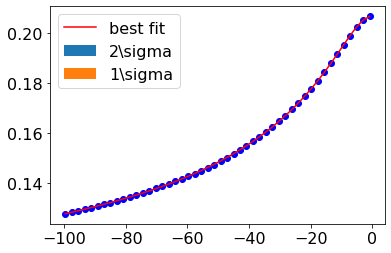



working case: q5_IMRPhenomD.p


[[Model]]
    Model(amp_merger_ansatz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 48
    # variables        = 4
    chi-square         = 2.7780e-06
    reduced chi-square = 6.3137e-08
    Akaike info crit   = -791.918831
    Bayesian info crit = -784.434027
[[Variables]]
    b0:  0.13145410 +/- 4.4783e-04 (0.34%) (init = 0)
    b1: -7.0610e-07 +/- 4.4783e-08 (6.34%) (init = 0)
    b2:  0.05781843 +/- 0.00103265 (1.79%) (init = 0)
    b3:  0.01914817 +/- 6.5442e-04 (3.42%) (init = 0)
    a1:  0.08826666 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.969
    C(b1, b2) =  0.939
    C(b0, b3) =  0.918
    C(b1, b3) = -0.856


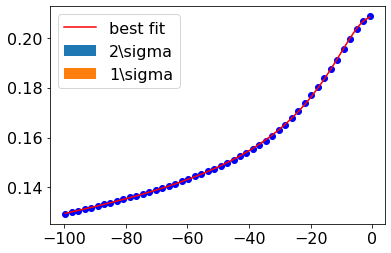



working case: q5_IMRPhenomC.p


[[Model]]
    Model(amp_merger_ansatz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 48
    # variables        = 4
    chi-square         = 2.6413e-04
    reduced chi-square = 6.0029e-06
    Akaike info crit   = -573.293704
    Bayesian info crit = -565.808900
[[Variables]]
    b0:  0.15826455 +/- 0.00436670 (2.76%) (init = 0)
    b1: -1.6875e-06 +/- 4.3667e-07 (25.88%) (init = 0)
    b2:  0.05442627 +/- 0.01006914 (18.50%) (init = 0)
    b3: -0.00202957 +/- 0.00638105 (314.40%) (init = 0)
    a1:  0.08826666 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(b0, b2) = -0.983
    C(b0, b1) = -0.977
    C(b2, b3) = -0.969
    C(b1, b2) =  0.939
    C(b0, b3) =  0.918
    C(b1, b3) = -0.856


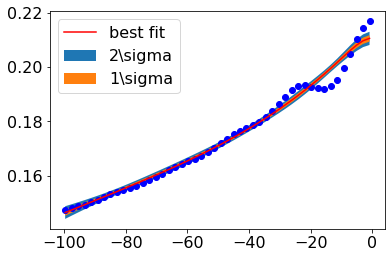

In [673]:
this_q = 5
fit_results = fit_cases(data, this_q)

In [674]:
fit_results[list(fit_results.keys())[0]].result

In [675]:
fit_results[list(fit_results.keys())[0]].result.params['b0'].value

0.12709705766302656

In [676]:
fit_results[list(fit_results.keys())[0]].result.params['b0'].stderr

0.0001560078108051111

In [677]:
fit_results[list(fit_results.keys())[0]].result.bic

-885.6671166034894

In [678]:
bics = {}
for k,v in fit_results.items():
    bics.update({k:v.result.bic})

In [679]:
bics

{'q5_Res3.p': -885.6671166034894,
 'q5_IMRPhenomB.p': -488.08909660818904,
 'q5_Res4.p': -903.9966003748611,
 'q5_SEOBNRv4.p': -823.3649419804261,
 'q5_Res5.p': -894.7272945158176,
 'q5_IMRPhenomD.p': -784.434027348479,
 'q5_IMRPhenomC.p': -565.8089000019781}

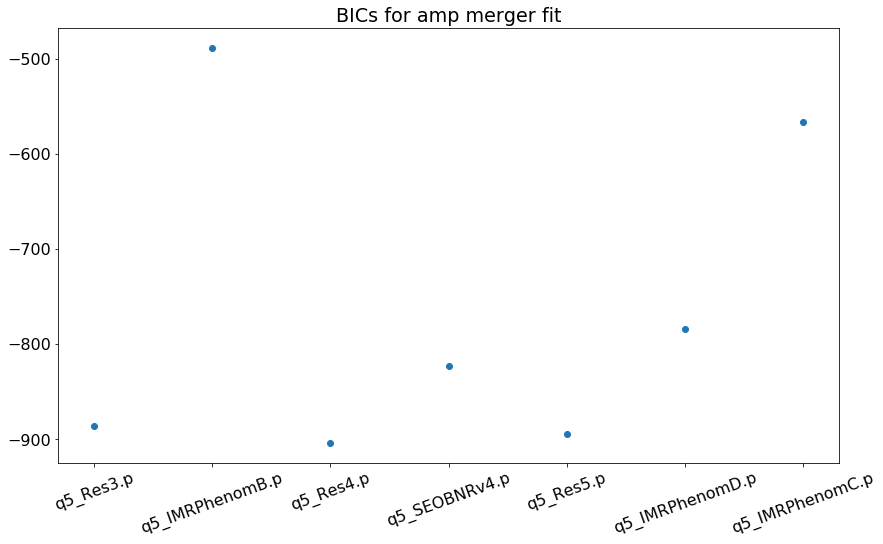

In [680]:
positions = range(len(bics))
plt.figure(figsize=(14, 8))
plt.scatter(positions, bics.values())
labels = list(bics.keys())
plt.xticks(positions, labels, rotation=20)
plt.title("BICs for amp merger fit");

In [681]:
def get_coeffs(fit_results):
    results={}
    for k,v in fit_results.items():
        params = v.result.params
        results.update({k:{}})
        for param_k, param_v in params.items():
            results[k].update({param_k:{'value':param_v.value, 'stderr':param_v.stderr}})
            
    return results

In [682]:
def get_x_y_yerr(coeffs_dict, param):
    # construct arrays to plot
    values = [coeff_results[key][param]['value'] for key in coeff_results.keys()]
    
    # the 1d sigma i.e. (sqrt(cov[i,i]))
    errors = [coeff_results[key][param]['stderr'] for key in coeff_results.keys()]
    
    x = np.arange(len(values))
    labels = list(coeff_results.keys())
    
    return x, values, errors, labels

In [683]:
def plot_coeffs(x, y, yerr, labels, ylim=None):
    
    plt.figure(figsize=(14, 4))
    plt.errorbar(x, y, yerr=yerr, ls='', marker='o')
    
    plt.xticks(x, labels, rotation=20)
    
    if ylim:
        plt.ylim(ylim)
    
    plt.show()
    plt.close()

In [684]:
coeff_results = get_coeffs(fit_results)

In [685]:
variable_params = ['b0', 'b1', 'b2', 'b3']



working parameter: b0




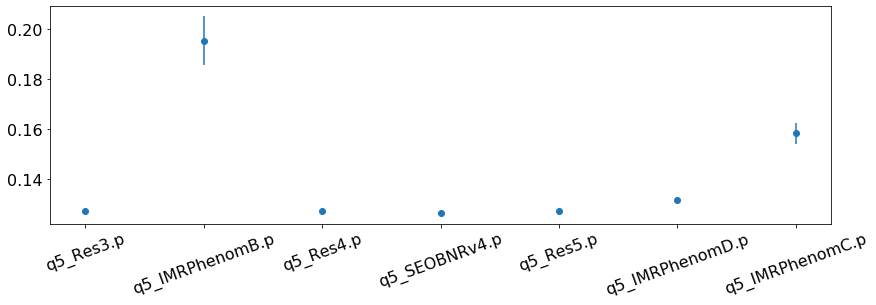

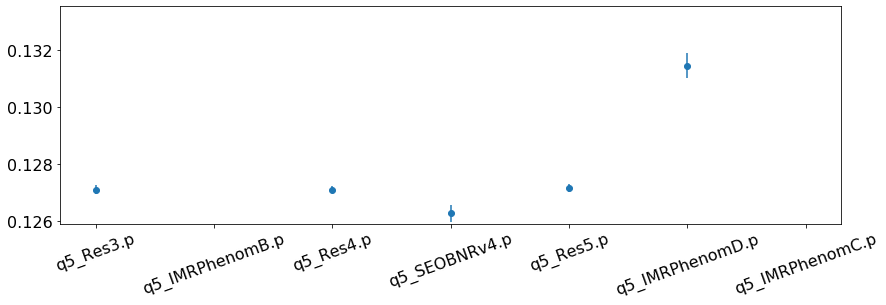



working parameter: b1




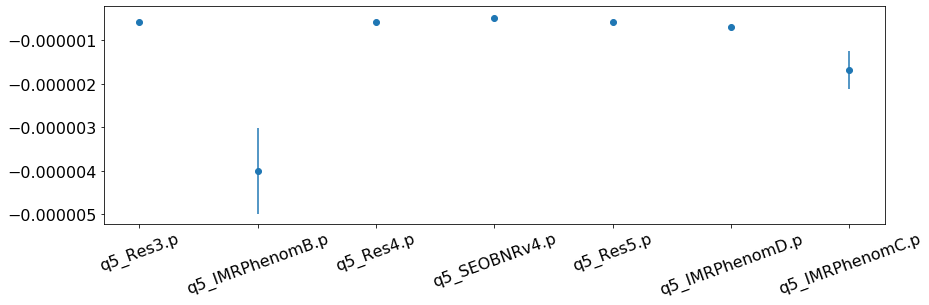

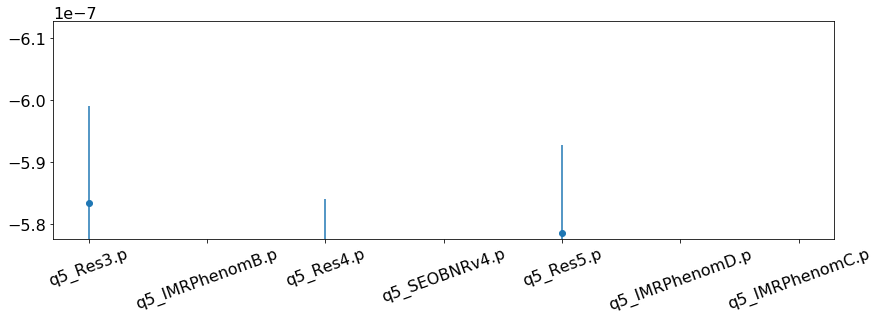



working parameter: b2




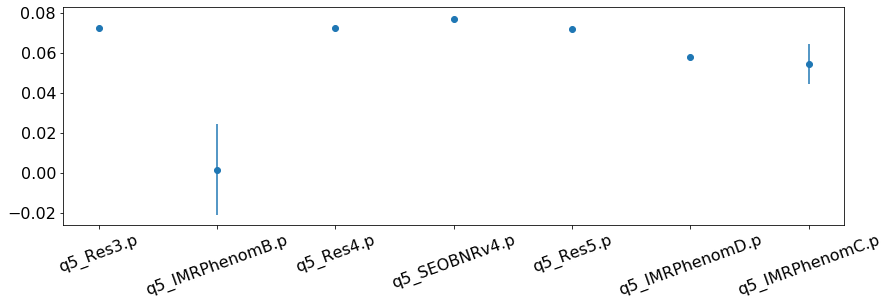

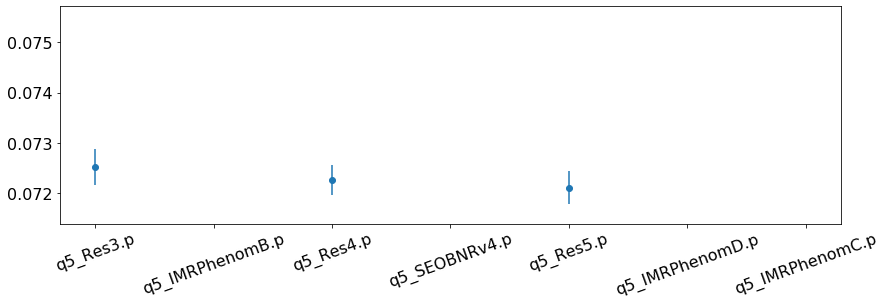



working parameter: b3




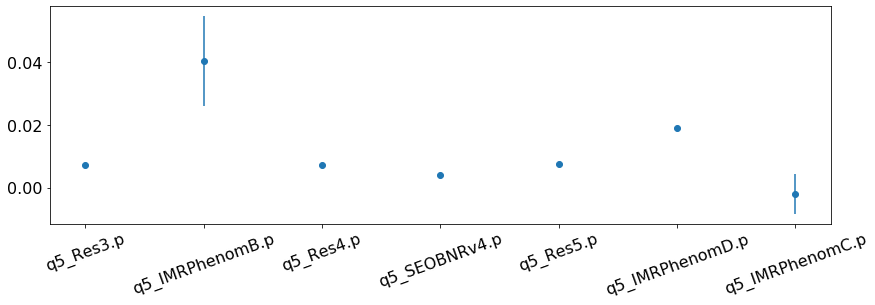

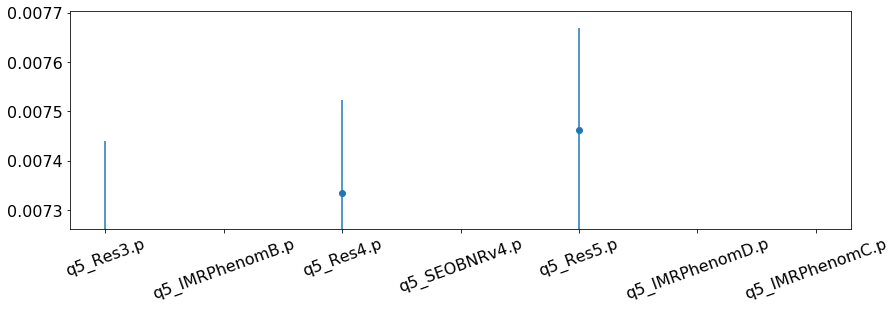

In [686]:
for par in variable_params:
    print("\n\n=============")
    print(f"working parameter: {par}")
    print("=============\n\n")

    x, y, yerr, labels = get_x_y_yerr(coeff_results, par)
    plot_coeffs(x, y, yerr, labels)
    # zoom
    plot_coeffs(x, y, yerr, labels, (np.median(y)*0.99, 1.05*np.median(y)))

In [687]:
# get ready to fit across parameter space
# parameter space fits (psf)

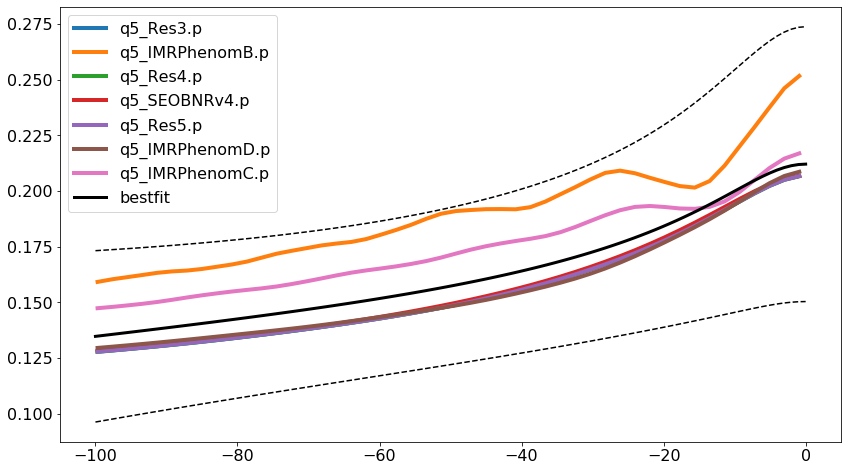

In [688]:
normalise = False
ys = {}
ynorms = {}
means = {}
stds = {}
for par in variable_params:
    x, y, yerr, labels = get_x_y_yerr(coeff_results, par)
    norm=np.max(np.abs(np.array(y)))
    
    if normalise:
        ynorms.update({par:norm})
        ys.update({par:np.array(y)/norm})
    else:
        ys.update({par:np.array(y)})
        
    means.update({par:np.mean(y)})
    stds.update({par:np.std(y)})
    
    



num = 1
means.update({'a1':get_fdamp(this_q)*2*np.pi})
stds.update({'a1':0})
    
up = means.copy()
down = means.copy()

for i in range(len(means)):
    k = list(means.keys())[i]
    up[k] = means[k] + num*stds[k]
    down[k] = means[k] - num*stds[k]
    
times = np.linspace(-100, 0, 100)
plt.figure(figsize=(14, 8))

for k,v in fit_results.items():
    plt.plot(v.userkws['t'], v.data, label=k, lw=4)

plt.plot(times, amp_merger_ansatz(times, **means), c='k', lw=3, label='bestfit')
plt.plot(times, amp_merger_ansatz(times, **up), c='k', ls='--')
plt.plot(times, amp_merger_ansatz(times, **down), c='k', ls='--')
    
plt.legend()

In [689]:
coeff_results.keys()

dict_keys(['q5_Res3.p', 'q5_IMRPhenomB.p', 'q5_Res4.p', 'q5_SEOBNRv4.p', 'q5_Res5.p', 'q5_IMRPhenomD.p', 'q5_IMRPhenomC.p'])

In [690]:
qs

[1, 2, 3, 4, 5, 10, 18]

In [691]:
ynorms

{}

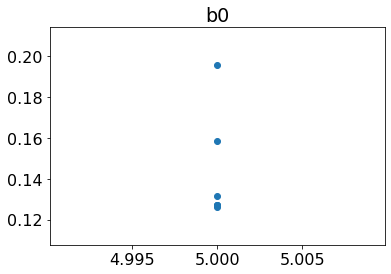

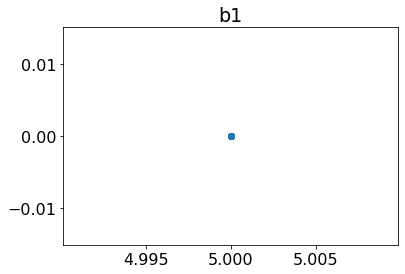

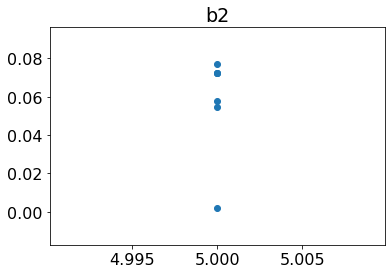

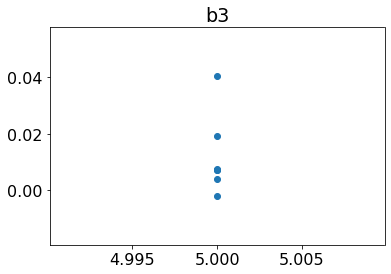

In [692]:
for par in variable_params:
    plt.figure()
    plt.scatter(np.ones(len(ys[par]))*this_q, ys[par])
    plt.title(par)